In [1]:

!pip install torch torchvision albumentations -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
annFile = "/content/drive/MyDrive/Colab Notebooks/VisionExtraction/annotations/instances_val2017.json"
root = "/content/drive/MyDrive/Colab Notebooks/VisionExtraction/val2017"

from torchvision.datasets import CocoDetection
dataset = CocoDetection(root=root, annFile=annFile)


loading annotations into memory...
Done (t=1.01s)
creating index...
index created!


In [4]:

from torchvision.datasets import CocoDetection
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Paths (update to your Google Drive structure)
train_root = "/content/drive/MyDrive/Colab Notebooks/VisionExtraction/val2017"  # only val2017 exists in your Drive
train_ann = "/content/drive/MyDrive/Colab Notebooks/VisionExtraction/annotations/instances_val2017.json"

val_root = "/content/drive/MyDrive/Colab Notebooks/VisionExtraction/val2017"
val_ann = "/content/drive/MyDrive/Colab Notebooks/VisionExtraction/annotations/instances_val2017.json"

!pip install pycocotools -q

# Custom dataset wrapper
class CocoSegmentation(torch.utils.data.Dataset):
    def __init__(self, root, annFile, transforms=None):
        self.dataset = CocoDetection(root, annFile)
        self.transforms = transforms

    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        img = np.array(img)

        # Create binary mask (object vs background)
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for obj in target:
            rle = self.dataset.coco.annToMask(obj)
            mask = np.maximum(mask, rle)

        # Convert mask to float32 before applying transforms
        mask = mask.astype(np.float32)

        if self.transforms:
            augmented = self.transforms(image=img, mask=mask)
            img, mask = augmented["image"], augmented["mask"]

        return img, mask.long()

    def __len__(self):
        return len(self.dataset)

# Augmentations
train_transform = A.Compose([
    A.Resize(height=256, width=256), # Resize first
    A.RandomCrop(height=256, width=256), # Then random crop
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


# Use val2017 for both train/val (since train2017 is not uploaded)
train_dataset = CocoSegmentation(
    root=train_root,
    annFile=train_ann,
    transforms=train_transform
)

val_dataset = CocoSegmentation(
    root=val_root,
    annFile=val_ann,
    transforms=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

print("Train images:", len(train_dataset), "Val images:", len(val_dataset))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
loading annotations into memory...
Done (t=0.79s)
creating index...
index created!
loading annotations into memory...
Done (t=0.84s)
creating index...
index created!
Train images: 5000 Val images: 5000


In [5]:
import torchvision.models.segmentation as models

# Model
model = models.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=1)  # 2 classes: background + object

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def dice_coefficient(pred, target, smooth=1e-6):
    pred = torch.argmax(pred, dim=1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)


In [7]:
num_epochs = 5  # try small first
best_val_dice = 0.0
save_path = "/content/drive/MyDrive/Colab Notebooks/VisionExtraction/best_model.pth"

for epoch in range(num_epochs):
    model.train()
    train_loss, train_dice = 0, 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_coefficient(outputs, masks).item()

    # Validation
    model.eval()
    val_loss, val_dice = 0, 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_dice += dice_coefficient(outputs, masks).item()

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Train Dice: {train_dice/len(train_loader):.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Dice: {val_dice/len(val_loader):.4f}")

    # Save best model
    if val_dice/len(val_loader) > best_val_dice:
        best_val_dice = val_dice/len(val_loader)
        torch.save(model.state_dict(), save_path)
        print("✅ Model saved!")


Epoch 1/5 | Train Loss: 0.3391, Train Dice: 0.7409 | Val Loss: 0.2594, Val Dice: 0.7964
✅ Model saved!
Epoch 2/5 | Train Loss: 0.2997, Train Dice: 0.7696 | Val Loss: 0.2515, Val Dice: 0.8018
✅ Model saved!
Epoch 3/5 | Train Loss: 0.2764, Train Dice: 0.7899 | Val Loss: 0.2250, Val Dice: 0.8261
✅ Model saved!
Epoch 4/5 | Train Loss: 0.2525, Train Dice: 0.8093 | Val Loss: 0.2146, Val Dice: 0.8328
✅ Model saved!
Epoch 5/5 | Train Loss: 0.2433, Train Dice: 0.8185 | Val Loss: 0.2098, Val Dice: 0.8420
✅ Model saved!


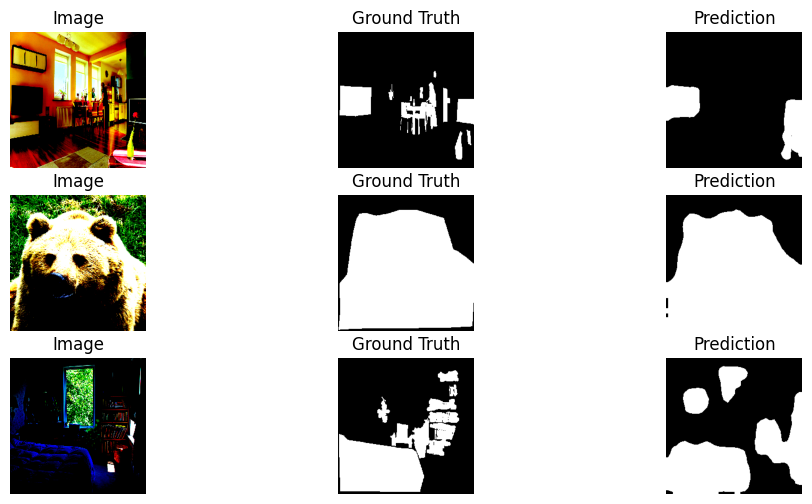

In [8]:
import matplotlib.pyplot as plt

model.eval()
images, masks = next(iter(val_loader))
images, masks = images.to(device), masks.to(device)

with torch.no_grad():
    outputs = model(images)['out']
preds = torch.argmax(outputs, dim=1).cpu().numpy()

plt.figure(figsize=(12,6))
for i in range(3):
    plt.subplot(3,3,i*3+1)
    plt.imshow(images[i].cpu().permute(1,2,0))
    plt.axis("off"); plt.title("Image")

    plt.subplot(3,3,i*3+2)
    plt.imshow(masks[i].cpu(), cmap="gray")
    plt.axis("off"); plt.title("Ground Truth")

    plt.subplot(3,3,i*3+3)
    plt.imshow(preds[i], cmap="gray")
    plt.axis("off"); plt.title("Prediction")

plt.show()
